In [331]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import eig, norm
from scipy import special
from scipy.linalg import fractional_matrix_power

# Helium Atom - Variational

In [12]:
def h_integral(zeta):
    return .5*zeta**2-2*zeta
def two_elec_integral(zeta):
    return 5/8 * zeta
def variational_energy_helium(zeta):
    return 2*h_integral(zeta)+two_elec_integral(zeta)

In [13]:
zeta_range = np.arange(1,2.5,.001)
e = variational_energy_helium(zeta_range)

In [14]:
x0 = [1.5]
res = minimize(variational_energy_helium, x0, method='nelder-mead',
               options={'xatol':1e-9,'disp': True})

Optimization terminated successfully.
         Current function value: -2.847656
         Iterations: 29
         Function evaluations: 63


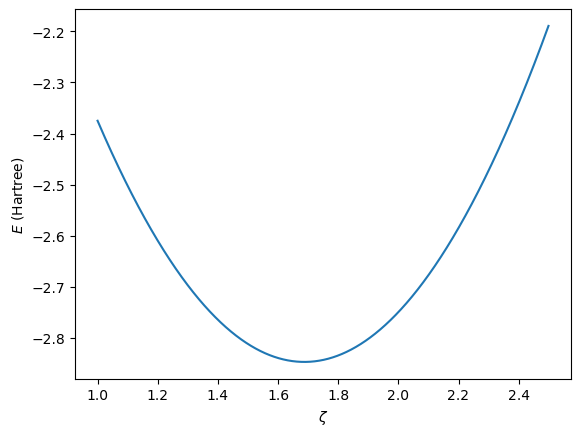

In [23]:
plt.plot(zeta_range, e)
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$E$ (Hartree)")
plt.show()

# Helium Atom HF

In [24]:
z1 = 1.45363
z2 = 2.91093

In [32]:
h11 = .5*z1**2-2*z1
h22 = .5*z2**2-2*z2
h12 = z1**(3/2)*z2**(3/2)*(4*z1*z2-8*z1-8*z2)/((z1+z2)**3)
Hmatr = np.array([[h11,h12],[h12,h22]])

In [41]:
j1111 = (5/8)*z1
j2222 = (5/8)*z2
j1122 = (z1**4 * z2 + 4 * z1**3 * z2**2 + z1*z2**4 + 4 * z1**2 * z2**3)/((z1+z2)**4)
j1212 = 20*z1**3*z2**3/((z1+z2)**5)
j1112 = (16*z1**(9/2)*z2**(3/2)/((3*z1+z2)**4))* \
((12*z1+8*z2)/((z1+z2)**2) + (9*z1+z2)/(2*z1**2))
j1222 = (16*z2**(9/2)*z1**(3/2)/((3*z2+z1)**4))* \
((12*z2+8*z1)/((z2+z1)**2) + (9*z2+z1)/(2*z2**2))

In [69]:
two_elec = np.empty((2,2,2,2)) # Two electron integrals matrix

In [70]:
two_elec[0,0,0,0] = j1111
two_elec[1,1,1,1] = j2222

two_elec[0,0,1,1] = j1122
two_elec[1,1,0,0] = j1122

two_elec[0,1,0,1] = j1212
two_elec[1,0,0,1] = j1212
two_elec[0,1,1,0] = j1212
two_elec[1,0,1,0] = j1212

two_elec[0,0,0,1] = j1112
two_elec[0,0,1,0] = j1112
two_elec[0,1,0,0] = j1112
two_elec[1,0,0,0] = j1112

two_elec[0,1,1,1] = j1222
two_elec[1,1,0,1] = j1222
two_elec[1,0,1,1] = j1222
two_elec[1,1,1,0] = j1222

In [71]:
s11 = 1
s22 = 1
s12 = 8*z1**(3/2)*z2**(3/2)/((z1+z2)**3) # Overlap Matrix Elements
Smatr = np.array([[s11,s12],[s12,s22]]) # Overlap Matrix

In [177]:
Xmatr = fractional_matrix_power(Smatr, -1/2) # Transform to orthogonal basis
print(Xmatr)

[[ 1.60929053 -0.87158414]
 [-0.87158414  1.60929053]]


In [78]:
coeff = np.zeros((2,2))

In [80]:
def sum_function(r,s,t,u):
    return coeff[1,t]*coeff[1,u]*two_elec[r,s,t,u]

In [204]:
def makePmatr(coeff):
    Pmatr = np.zeros((nBasis,nBasis))
    for t in range(0,nBasis):
        for u in range(0,nBasis):
            for i in range(0,nOcc):
                Pmatr[t,u] += 2*coeff[i,t]*coeff[i,u]
    return Pmatr

In [205]:
def makeFmatr_old(Hmatr, coeff):
    F = Hmatr.copy()
    for r in range(nBasis):
        for s in range(nBasis):
            for t in range(nBasis):
                for u in range(nBasis):
                    F[r,s] += sum_function(r,s,t,u)
    return F
def makeFmatr(Hmatr, Pmatr):
    F = np.empty((nBasis, nBasis))
    for r in range(nBasis):
        for s in range(nBasis):
            F[r,s] = Hmatr[r,s]
            for t in range(nBasis):
                for u in range(nBasis):
                    F[r,s] += Pmatr[t,u]*(two_elec[r,s,t,u]-.5*two_elec[r,u,t,s])
    return F

In [210]:
coeff = np.zeros((2,2))
Fmatr = makeFmatr_old(Hmatr, coeff)
evals, coeff = eig(Xmatr.conj().T @ Fmatr @ Xmatr)
coeff = coeff.T
for i in range(2):
    coeff[i] =Xmatr @ coeff[i]
makeFmatr_old(Hmatr, coeff)

array([[-0.94321222, -0.92218968],
       [-0.92218968, -0.24837557]])

In [208]:
def calcHFenergy(sortedEvals, Hmatr, Pmatr, Vnn):
    energy = sortedEvals[0:nOcc].sum()
    for r in range(nBasis):
        for s in range(nBasis):
            energy += .5*Pmatr[r,s]*Hmatr[r,s]
    energy += Vnn
    return energy

In [224]:
nBasis = 2
nOcc = 1
coeff = np.zeros((2,2))
Pmatr = makePmatr(coeff)
energies = []
for j in range(0,10):
    Fmatr = makeFmatr(Hmatr, Pmatr)
    Fprime = Xmatr.conj().T @ Fmatr @ Xmatr
    eigenValues, eigenVectors = eig(Fprime)
    coeff = eigenVectors.T
    # print(coeff)
    for i in range(nBasis):
        coeff[i] = Xmatr @ coeff[i]
    sorting = eigenValues.argsort()[::1]
    eigenValues = eigenValues[sorting]

    coeff = coeff[sorting]

    Pmatr = makePmatr(coeff)
    energy = calcHFenergy(eigenValues, Hmatr, Pmatr, 0)
    energies.append(energy)
    print(f"Iteration: {j+1} Energy: {energy}")

Iteration: 1 Energy: -3.9592393540595516
Iteration: 2 Energy: -2.7845718692620722
Iteration: 3 Energy: -2.858598372056244
Iteration: 4 Energy: -2.8615227606191795
Iteration: 5 Energy: -2.8616652258793556
Iteration: 6 Energy: -2.8616722348933363
Iteration: 7 Energy: -2.8616725798900475
Iteration: 8 Energy: -2.8616725968718333
Iteration: 9 Energy: -2.8616725977077286
Iteration: 10 Energy: -2.8616725977488744


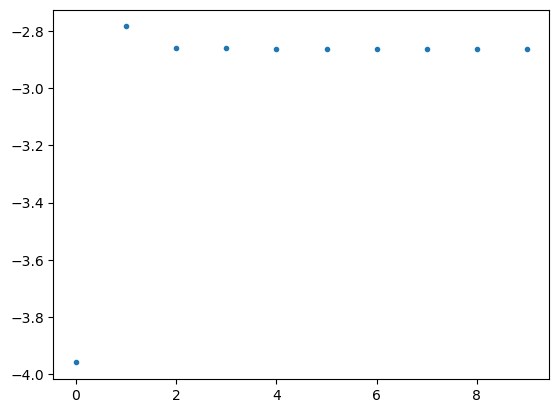

In [225]:
plt.plot(energies, ".")
plt.show()

# Hydrogen Molecule

In [277]:
def g1s_unnorm(alpha, rA):
    return np.exp(-alpha*(np.dot(rA, rA)))
def g1s_norm_const(alpha):
    return (2*alpha/np.pi)**(3/4)
def g1s(alpha, rA):
    return g1s_norm_const(alpha)*g1s_unnorm(alpha, rA)

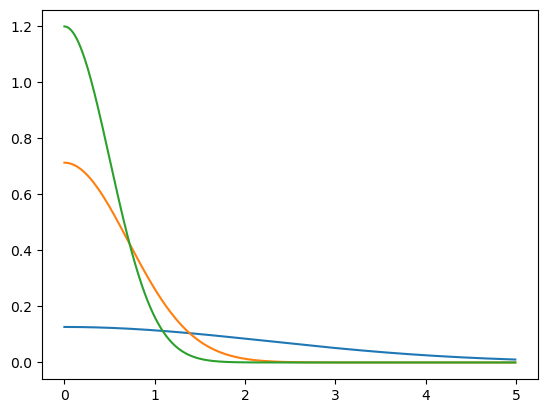

In [278]:
z = np.arange(0,5,.01)
plt.plot(z, list(map(lambda x: g1s(.1, x), z)))
plt.plot(z, list(map(lambda x: g1s(1, x), z)))
plt.plot(z, list(map(lambda x: g1s(2, x), z)))
plt.show()

In [350]:
def propK(alpha, rA, beta, rB):
    # print(rA-rB)
    value =  np.exp(-alpha * beta * np.dot(rA-rB, rA-rB)/(alpha+beta))
    return value
def rP(alpha, rA, beta, rB):
    return (alpha*rA+beta*rB)/(alpha+beta)
def p(alpha, beta):
    return alpha+beta

In [351]:
def overlapInt(alpha, rA, beta, rB):
    return g1s_norm_const(alpha)*g1s_norm_const(beta)*propK(alpha, rA, beta, rB)*(np.pi/(alpha+beta))**(3/2)
def kineticEnInt(alpha, rA, beta, rB):
    return g1s_norm_const(alpha)*g1s_norm_const(beta)*propK(alpha, rA, beta, rB)\
    * (((alpha*beta)/(alpha+beta))*(3-(2*alpha*beta*np.dot(rA-rB, rA-rB)/(alpha+beta))))\
    * (np.pi/(alpha+beta))**(3/2)
def f0func(t):
    value =  special.erf((t+10e-10)**(1/2))*((np.pi/(t+10e-10))**(1/2)) / 2
    return(value)
def nuclearInt(alpha, rA, beta, rB, Zc, rC):
    return -Zc * g1s_norm_const(alpha) * g1s_norm_const(beta) * propK(alpha, rA, beta, rB) * \
    (2 * np.pi / (alpha+beta)) * f0func((alpha+beta)*np.dot((rP(alpha, rA, beta, rB)-rC), (rP(alpha, rA, beta, rB)-rC)))
def twoElecInt(alpha, rA, beta, rB, gamma, rC, delta, rD):
    return propK(alpha, rA, beta, rB) * propK(gamma, rC, delta, rD) * \
    g1s_norm_const(alpha) * g1s_norm_const(beta) * g1s_norm_const(gamma) * g1s_norm_const(delta) * \
    ((2*np.pi**(5/2))/((alpha+beta)*(gamma+delta)*np.sqrt(alpha+beta+gamma+delta))) * \
    f0func((alpha+beta)*(gamma+delta)*\
          np.dot((rP(alpha, rA, beta, rB)-rP(gamma, rC, delta, rD)), (rP(alpha, rA, beta, rB)-rP(gamma, rC, delta, rD))) / (alpha+beta+gamma+delta))

In [352]:
nAtom = 2
nBasis = 2
nOcc = 1
atomPos = np.array([[0,0,0],[0,0,1.6]])
atomZ = np.array([1,1])
basisPos = np.array([[0,0,0],[0,0,1.6]])
basisOrb = np.array([.4166, .4166])

In [353]:
Smatr = np.empty((nBasis, nBasis))
for i in range(nBasis):
    for j in range(nBasis):
        Smatr[i,j]= overlapInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j])
print(Smatr)

[[1.         0.58669628]
 [0.58669628 1.        ]]


In [354]:
Xmatr = fractional_matrix_power(Smatr, -1/2) # Transform to orthogonal basis
print(Xmatr)

[[ 1.17468002 -0.38080325]
 [-0.38080325  1.17468002]]


In [355]:
Hmatr = np.empty((nBasis, nBasis))
for i in range(nBasis):
    for j in range(nBasis):
        Hmatr[i,j] = kineticEnInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j])
        for k in range(nAtom):
            Hmatr[i,j] += nuclearInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j], atomZ[k], atomPos[k])
print(Hmatr)

[[-1.00578043 -0.78787764]
 [-0.78787764 -1.00578043]]


In [356]:
two_elec = np.empty((nBasis, nBasis, nBasis, nBasis))

for i in range(nBasis):
    for j in range(nBasis):
        for k in range(nBasis):
            for l in range(nBasis):
                value = twoElecInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j], basisOrb[k], basisPos[k], basisOrb[l], basisPos[l])
                two_elec[i,j,k,l] = value
print(two_elec)

[[[[0.72830735 0.39217381]
   [0.39217381 0.53490055]]

  [[0.39217381 0.25069251]
   [0.25069251 0.39217381]]]


 [[[0.39217381 0.25069251]
   [0.25069251 0.39217381]]

  [[0.53490055 0.39217381]
   [0.39217381 0.72830735]]]]


In [357]:
Vnn = 0
for cp in range(1, nAtom):
    for c in range(0, cp):
        Vnn += atomZ[c]*atomZ[cp]/norm(atomPos[c]-atomPos[cp])


In [358]:
coeff = np.zeros((2,2))
Pmatr = makePmatr(coeff)
energies = []
for j in range(0,10):
    Fmatr = makeFmatr(Hmatr, Pmatr)
    Fprime = Xmatr.conj().T @ Fmatr @ Xmatr
    eigenValues, eigenVectors = eig(Fprime)
    coeff = eigenVectors.T
    # print(coeff)
    for i in range(nBasis):
        coeff[i] = Xmatr @ coeff[i]
    sorting = eigenValues.argsort()[::1]
    eigenValues = eigenValues[sorting]

    coeff = coeff[sorting]

    Pmatr = makePmatr(coeff)
    energy = calcHFenergy(eigenValues, Hmatr, Pmatr, Vnn)
    energies.append(energy)
    print(f"Iteration: {j+1} Energy: {energy}")

Iteration: 1 Energy: -1.6358713368161677
Iteration: 2 Energy: -0.9738755022553378
Iteration: 3 Energy: -0.9738755022553374
Iteration: 4 Energy: -0.9738755022553376
Iteration: 5 Energy: -0.9738755022553378
Iteration: 6 Energy: -0.9738755022553376
Iteration: 7 Energy: -0.9738755022553378
Iteration: 8 Energy: -0.9738755022553376
Iteration: 9 Energy: -0.9738755022553378
Iteration: 10 Energy: -0.9738755022553376


In [367]:
def HF(dist):
    nAtom = 2
    nBasis = 2
    nOcc = 1
    atomZ = np.array([1,1])
    basisOrb = np.array([.4166, .4166])
    atomPos = np.array([[0,0,0],[0,0,dist]])
    basisPos = np.array([[0,0,0],[0,0,dist]])
    
    Smatr = np.empty((nBasis, nBasis))
    for i in range(nBasis):
        for j in range(nBasis):
            Smatr[i,j]= overlapInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j])
    Xmatr = fractional_matrix_power(Smatr, -1/2) # Transform to orthogonal basis
    
    Hmatr = np.empty((nBasis, nBasis))
    for i in range(nBasis):
        for j in range(nBasis):
            Hmatr[i,j] = kineticEnInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j])
            for k in range(nAtom):
                Hmatr[i,j] += nuclearInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j], atomZ[k], atomPos[k])

    two_elec = np.empty((nBasis, nBasis, nBasis, nBasis))
    for i in range(nBasis):
        for j in range(nBasis):
            for k in range(nBasis):
                for l in range(nBasis):
                    value = twoElecInt(basisOrb[i], basisPos[i], basisOrb[j], basisPos[j], basisOrb[k], basisPos[k], basisOrb[l], basisPos[l])
                    two_elec[i,j,k,l] = value
    Vnn = 0
    for cp in range(1, nAtom):
        for c in range(0, cp):
            Vnn += atomZ[c]*atomZ[cp]/norm(atomPos[c]-atomPos[cp])
        
    
    coeff = np.zeros((2,2))
    Pmatr = makePmatr(coeff)
    energies = []
    energy = 0
    for j in range(0,10):
        Fmatr = makeFmatr(Hmatr, Pmatr)
        Fprime = Xmatr.conj().T @ Fmatr @ Xmatr
        eigenValues, eigenVectors = eig(Fprime)
        coeff = eigenVectors.T
        # print(coeff)
        for i in range(nBasis):
            coeff[i] = Xmatr @ coeff[i]
        sorting = eigenValues.argsort()[::1]
        eigenValues = eigenValues[sorting]
    
        coeff = coeff[sorting]
    
        Pmatr = makePmatr(coeff)
        energy = calcHFenergy(eigenValues, Hmatr, Pmatr, Vnn)
    return energy

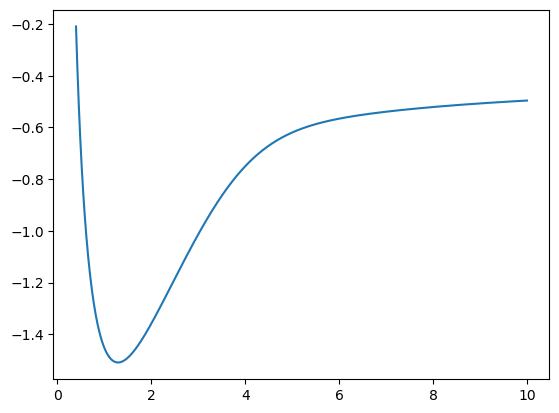

In [371]:
dists = []
energies = []
for i in np.arange(0.4, 10, .01):
    dists.append(i)
    energies.append(HF(i))
plt.plot(dists, energies)
plt.show()